## Split Dataset in train and validation set

In [1]:
%matplotlib inline

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
from sklearn import tree
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
import pydotplus
from IPython.display import Image
import graphviz
import itertools
import seaborn as sns

In [8]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [9]:
path = '~/Documents/dmproject/datasets/'

In [10]:
df = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')

In [11]:
# Define function to find missing values
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"+"There are " + str(mis_val_table_ren_columns.shape[0]) +" columns that have missing values.")        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [12]:
df_discretized = df.copy()
df_test_discretized = df_test.copy()

In [13]:
#function to discretize the variables
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable] = dataset[variable].map(mapping).astype(int)
    return dataset

In [14]:
df_discretized

,TotalItems,DistinctItems,MaxItems,Entropy,TotalSale,Frequency,CustomerCountry,MonthSale,WeekSale,MonthFrequency,WeekFrequency,Recency,MonthItems,WeekItems,MonthDistinctItems,WeekDistinctItems,EntropyMonth,EntropyWeek,CustomerLabel
0,594,179,250,7.392,375.37,210,United Kingdom,37.537,8.730,21.000,4.884,41,59.400,13.814,19.400,4.605,1.437,1.540,high-spending
1,304,36,148,5.107,125.22,42,United Kingdom,11.384,2.722,3.818,0.913,23,27.636,6.609,3.818,0.913,1.719,1.719,medium-spending
2,768,71,224,6.080,221.98,82,Singapore,22.198,5.414,8.200,2.000,52,76.800,18.732,8.200,2.000,2.127,2.206,high-spending
3,354,98,95,6.447,426.26,145,United Kingdom,47.362,10.930,16.111,3.718,73,39.333,9.077,15.667,3.692,1.929,2.270,high-spending
4,96,11,96,3.459,23.65,11,United Kingdom,2.956,0.763,1.375,0.355,101,12.000,3.097,1.375,0.355,1.000,0.310,low-spending
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3316,270,24,146,4.547,53.98,26,Germany,4.907,1.200,2.364,0.578,29,24.545,6.000,2.364,0.578,0.964,0.964,low-spending
3317,10,1,10,1.000,2.08,1,United Kingdom,0.231,0.058,0.111,0.028,60,1.111,0.278,0.111,0.028,0.918,0.918,low-spending
3318,151,39,79,5.194,108.81,48,United Kingdom,9.892,2.418,4.364,1.067,33,13.727,3.356,4.273,1.044,0.961,0.961,medium-spending
3319,15,4,15,2.000,17.10,4,United Kingdom,5.700,1.900,1.333,0.444,280,5.000,1.667,1.333,0.444,1.000,1.000,medium-spending


In [15]:
#discretize the variable
variables = ['CustomerCountry', 'CustomerLabel' ]
df_discretized = discretize_data(df_discretized, variables)
df_test_discretized = discretize_data(df_test_discretized, variables)

In [16]:
df_discretized = df_discretized.drop(columns=['TotalSale','MonthSale','WeekSale'])
df_test_discretized = df_test_discretized.drop(columns=['TotalSale','MonthSale','WeekSale'])

In [17]:
# unskew the data
# rfm_log = df_discretized[['TotalSale', 'TotalItems', 'DistinctItems', 'MaxItems', 'Entropy', 'Frequency']].apply(np.log, axis = 1).round(3)
rfm_log = df_discretized[['DistinctItems', 'MaxItems', 'Entropy', 'Frequency']].apply(np.log, axis = 1).round(3)
rfm_test = df_test_discretized[['DistinctItems', 'MaxItems', 'Entropy', 'Frequency']].apply(np.log, axis = 1).round(3)

In [18]:
# scale the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(rfm_log)# transform into a dataframe
df_test_scaled = scaler.fit_transform(rfm_test)
df_scaled = pd.DataFrame(df_scaled, index = rfm_log.index, columns = rfm_log.columns)
df_test_scaled = pd.DataFrame(df_test_scaled, index = rfm_test.index, columns = rfm_test.columns)

In [19]:
#to classify, we first need to split the dataset into train and test dataset.
#we can do so using train_test_split, in this case we select a stratified split
df_knn = df_discretized.copy()
label = df_knn.pop('CustomerLabel')
#label = df_discretized.pop('customer_type')
X_train, X_val, y_train, y_val = train_test_split(df_knn, label, stratify = label, test_size=0.30)
X_test = df_test_discretized.drop(columns=['CustomerLabel'])
y_test = df_test_discretized['CustomerLabel']

## KNN

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
from sklearn import tree
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
import pydotplus
from IPython.display import Image
import graphviz
import itertools
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [21]:
param_grid = {'n_neighbors': list(range(1, 31, 3)),
              'weights': ['uniform', 'distance'],
             }

clf = GridSearchCV(KNeighborsClassifier(), param_grid, cv=StratifiedKFold(5), scoring='accuracy')
clf_fit = clf.fit(X_train, y_train)

# tree_performance = roc_auc_score(y_val, clf_fit.predict(X_val))
# print("DecisionTree: Area under the ROC curve = {}".format(tree_performance))
opt_df = clf_fit.best_estimator_
print("{}".format(clf_fit.best_params_))
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_val, clf.predict(X_val)
print(classification_report(y_true, y_pred))
print()

{'n_neighbors': 7, 'weights': 'distance'}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.86      0.81      0.83       253
           1       0.84      0.91      0.87       347
           2       0.79      0.76      0.78       397

    accuracy                           0.83       997
   macro avg       0.83      0.83      0.83       997
weighted avg       0.83      0.83      0.82       997




In [17]:
result = opt_df.score(X_test, y_test)
print("Accuracy: %.2f%%" % (result*100.0))

Accuracy: 82.67%


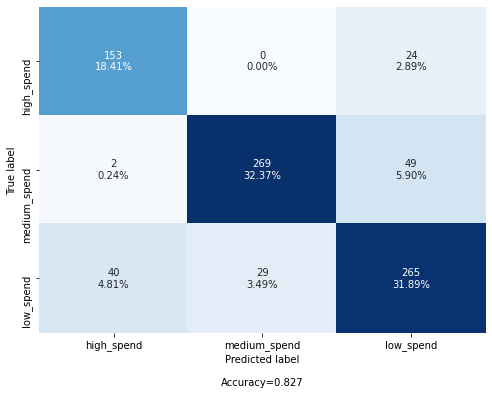

In [18]:
y_pred = opt_df.predict(X_test)
cf_matrix = confusion_matrix(y_pred, y_test)
labels = ['high_spend','medium_spend','low_spend']
cf_matrix
make_confusion_matrix(cf_matrix,categories=labels, figsize=(8,6), cbar=False)

In [19]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

probs = opt_df.predict_proba(X_test)
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, probs[:,i], pos_label=i)
    
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

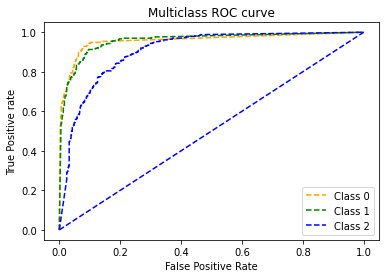

In [20]:
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
# plt.savefig('Multiclass ROC',dpi=300)